# Notebook - Dallas Morning News Case Study

The Dallas Morning News [uncovers a cheating scandal on the TAKS test](http://clipfile.org/?p=754). 

_note: Try not to consult the clip above unless you're stuck. The clip also doesn't contain all of the answers so there is still plenty to investigate._

> You're a reporter at the Dallas Morning News in 2005. While talking to some teachers at your local school district, you recieved a tip that a **fourth grade classroom at Harrell Budd Elementary in southern Dallas has unusually high test scores in reading** on the TAKS test (the state's standardized test to measure student progress). To check out this claim you've downloaded data from the Texas Education Agency. To dig deeper into this, you have acquired records from the district of average standardized TAKS test scores for reading and math for third, fourth and fifth graders for the previous year. You also decide to download the reading scores for 2003.

Let's see how the Dallas Morning News used regressions to find evidence of this claim and try to find out if it is an isolated case.

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **cfy04e4.dat:** 2004 fourth-grade TAKS scores - standardized test scores for 2004's fourth-graders
* **cfy04e5.dat:** 2004 fifth-grade TAKS scores - standardized test scores for 2004's fifth-graders
* **cfy04e3.dat:** 2004 third-grade TAKS scores - standardized test scores for 2004's third-graders

More data you might want
* **cfy03e3.dat:** 2003 third-grade TAKS scores - standardized test scores for 2003's third-graders

Data Documentation: 
https://tea.texas.gov/student-assessment/testing/taks-resources/taks-variables-formats-and-descriptions


In [1]:
# # Make data directory if it doesn't exist
# # (you can remove the comments, run this cell once to download the data, and add the comments back)
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e5.dat -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e3.dat -P data

--2025-02-25 15:00:03--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy04e4.dat
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15699181 (15M) [application/octet-stream]
Saving to: ‘data/cfy04e4.dat’

cfy04e4.dat         100%[===================>]  14.97M  3.42MB/s    in 5.6s    

2025-02-25 15:00:09 (2.68 MB/s) - ‘data/cfy04e4.dat’ saved [15699181/15699181]

--2025-02-25 15:00:09--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/dmn-texas-school-cheating/data/cfy03e3.dat
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11669172 (11M) [application/oc

### R and Python Imports

In [2]:
%reload_ext rpy2.ipython
%reload_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

In [3]:
%%R

require('tidyverse')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: tidyverse


In [4]:
import pandas as pd
import numpy as np

# Show a large number of rows and columns when displaying dfs
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
from IPython.display import display, HTML

# Finding suspicious datapoints with linear regression

Can we see evidence of possible cheating at Harrell Budd Elementary? Is Harrell Budd Elementary's fourth grade reading classrooms the only place where we see signs of possible cheating in 2004? 

How else can you design regressions to help you uncover other instances of cheating? Let's build a model to find out.

![](residuals.png)


## Load the data 
We'll start by opening up our dataset - standardized test performance at each school. We have:
- 3rd 4th and 5th grade reading and math scores for 2004 
- 4th grade reading and math scores for 2003

In [5]:
df_third_grade_2004 = pd.read_csv("data/cfy04e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third_2004')
df_fourth_grade_2004 = pd.read_csv("data/cfy04e4.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fourth_2004')
df_fifth_grade_2004 = pd.read_csv("data/cfy04e5.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_fifth_2004')

# This time I'm also adding fourth grade scores from last year (2003)! 
df_third_grade_2003 = pd.read_csv("data/cfy03e3.dat", usecols=['r_all_rs', 'm_all_rs', 'CNAME', 'CAMPUS']).set_index('CAMPUS').add_suffix('_third_2003')

# Display the first 3 rows of each df
display(df_third_grade_2004.head(3))
display(df_fourth_grade_2004.head(3))
display(df_fifth_grade_2004.head(3))
display(df_third_grade_2003.head(3))


,CNAME_third_2004,r_all_rs_third_2004,m_all_rs_third_2004
CAMPUS,,,
1902103,CAYUGA EL,2410.0,2388.0
1903101,ELKHART EL,2256.0,2208.0
1904102,FRANKSTON EL,2284.0,2313.0


,CNAME_fourth_2004,r_all_rs_fourth_2004,m_all_rs_fourth_2004
CAMPUS,,,
1902103,CAYUGA EL,2392.0,2227.0
1903101,ELKHART EL,2263.0,2192.0
1904102,FRANKSTON EL,2242.0,2152.0


,CNAME_fifth_2004,r_all_rs_fifth_2004,m_all_rs_fifth_2004
CAMPUS,,,
1902103,CAYUGA EL,2308.0,2317.0
1903101,ELKHART EL,2193.0,2153.0
1904102,FRANKSTON EL,2288.0,2256.0


,CNAME_third_2003,r_all_rs_third_2003,m_all_rs_third_2003
CAMPUS,,,
1902103,CAYUGA EL,2330.0,2350.0
1903101,ELKHART EL,2285.0,2183.0
1904102,FRANKSTON EL,2299.0,2248.0


## Clean The Data 🧹

In [6]:
# Combine the above dataframes, remove duplicate columns
df = pd.concat([df_third_grade_2004, df_fourth_grade_2004, df_fifth_grade_2004, df_third_grade_2003], axis=1)
df['CNAME'] = df['CNAME_third_2004'].fillna(df['CNAME_fourth_2004']).fillna(df['CNAME_fifth_2004']).fillna(df['CNAME_third_2003'])
df = df.drop(columns=['CNAME_third_2004', 'CNAME_fourth_2004', 'CNAME_fifth_2004', 'CNAME_third_2003'])
df = df.reset_index()

# remove _all_rs from column names
df.columns = df.columns.str.replace('_all_rs', '')

# display
df


,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME
0,1902103,2410.0,2388.0,2392.0,2227.0,2308.0,2317.0,2330.0,2350.0,CAYUGA EL
1,1903101,2256.0,2208.0,2263.0,2192.0,2193.0,2153.0,2285.0,2183.0,ELKHART EL
2,1904102,2284.0,2313.0,2242.0,2152.0,2288.0,2256.0,2299.0,2248.0,FRANKSTON EL
3,1906102,2294.0,2273.0,2218.0,2096.0,2298.0,2312.0,2236.0,2223.0,NECHES EL
4,1907110,2256.0,2205.0,2200.0,2168.0,2218.0,2269.0,2202.0,2142.0,STORY EL
...,...,...,...,...,...,...,...,...,...,...
4279,221901123,NaN,NaN,NaN,NaN,NaN,NaN,2284.0,2174.0,VALLEY VIEW EL
4280,226906180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRAPE CREEK SPE
4281,227913101,NaN,NaN,NaN,NaN,NaN,NaN,2364.0,2310.0,LAKE TRAVIS EL
4282,233901104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARION RUSSELL


In [7]:
# Here is the dataframe above in long format if you'd prefer it that way!
df_long = df.melt(id_vars=['CAMPUS', 'CNAME'], var_name='test_type', value_name='score').dropna()
df_long

,CAMPUS,CNAME,test_type,score
0,1902103,CAYUGA EL,r_third_2004,2410.0
1,1903101,ELKHART EL,r_third_2004,2256.0
2,1904102,FRANKSTON EL,r_third_2004,2284.0
3,1906102,NECHES EL,r_third_2004,2294.0
4,1907110,STORY EL,r_third_2004,2256.0
...,...,...,...,...
34264,220908102,ERMA NASH ELEME,m_third_2003,2183.0
34266,221901101,ALTA VISTA EL,m_third_2003,2212.0
34267,221901123,VALLEY VIEW EL,m_third_2003,2174.0
34269,227913101,LAKE TRAVIS EL,m_third_2003,2310.0


# Explore the data

Let's see where `HARRELL BUDD EL` stands in the 2004 fourth grade reading scores (our tip).

In [8]:
df = df.sort_values(by='r_fourth_2004', ascending=False)
df

,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME
2525,131001103,2355.0,2342.0,2509.0,2520.0,NaN,NaN,2424.0,2325.0,SARITA EL
1985,101912296,2438.0,2459.0,2480.0,2494.0,2455.0,2538.0,2469.0,2514.0,T H ROGERS EL
799,57905115,2160.0,2168.0,2470.0,2394.0,2127.0,2209.0,2140.0,2081.0,HARRELL BUDD EL
2916,180901101,2363.0,2385.0,2448.0,2397.0,2169.0,2126.0,2294.0,2164.0,MIMI FARLEY ELE
1236,68901118,2454.0,2373.0,2432.0,2444.0,2426.0,2482.0,2431.0,2359.0,EL MAGNET AT RE
...,...,...,...,...,...,...,...,...,...,...
4279,221901123,NaN,NaN,NaN,NaN,NaN,NaN,2284.0,2174.0,VALLEY VIEW EL
4280,226906180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GRAPE CREEK SPE
4281,227913101,NaN,NaN,NaN,NaN,NaN,NaN,2364.0,2310.0,LAKE TRAVIS EL
4282,233901104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MARION RUSSELL


Looks like `HARRELL BUDD EL` has a fourth grade reading score of 2470. that's the third highest of all the schools in Texas! 

Let's look at that in context of all of the reading scores in 2004.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 578 rows containing non-finite outside the scale range (`stat_bin()`). 



In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


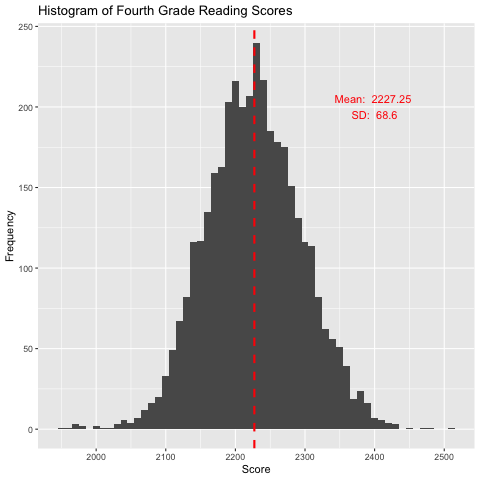

In [9]:
%%R -i df 

# Make a histogram of only fourth grade reading scores
df %>% 
  ggplot(aes(r_fourth_2004)) +
  geom_histogram(binwidth = 10) +
  # remove nulls and plot mean as a vline
  geom_vline(aes(xintercept=mean(r_fourth_2004, na.rm=TRUE)), color="red", linetype="dashed", size=1) +
  # show mean and sd on x=2400, y=200
  annotate("text", x=2400, y=200, label=paste("Mean: ", round(mean(df$r_fourth_2004, na.rm=TRUE), 2), "\nSD: ", round(sd(df$r_fourth_2004, na.rm=TRUE), 2)), color="red") +
  labs(title = "Histogram of Fourth Grade Reading Scores", x = "Score", y = "Frequency")

The 2004 reading scores of `HARRELL BUDD EL` has a z-score of 3.538760. What should we make of that?


In [10]:
# standardize r_fourth_2004 into a z-score in python
df['r_fourth_2004_z'] = (df['r_fourth_2004'] - df['r_fourth_2004'].mean()) / df['r_fourth_2004'].std()
df.head(20)

,CAMPUS,r_third_2004,m_third_2004,r_fourth_2004,m_fourth_2004,r_fifth_2004,m_fifth_2004,r_third_2003,m_third_2003,CNAME,r_fourth_2004_z
2525,131001103,2355.0,2342.0,2509.0,2520.0,NaN,NaN,2424.0,2325.0,SARITA EL,4.107282
1985,101912296,2438.0,2459.0,2480.0,2494.0,2455.0,2538.0,2469.0,2514.0,T H ROGERS EL,3.684535
799,57905115,2160.0,2168.0,2470.0,2394.0,2127.0,2209.0,2140.0,2081.0,HARRELL BUDD EL,3.538760
2916,180901101,2363.0,2385.0,2448.0,2397.0,2169.0,2126.0,2294.0,2164.0,MIMI FARLEY ELE,3.218055
1236,68901118,2454.0,2373.0,2432.0,2444.0,2426.0,2482.0,2431.0,2359.0,EL MAGNET AT RE,2.984815
962,57909122,2392.0,2404.0,2430.0,2431.0,2463.0,2479.0,2386.0,2324.0,WALNUT GLEN ACA,2.955660
1089,57916123,2409.0,2354.0,2426.0,2438.0,2387.0,2369.0,2426.0,2355.0,PRAIRIE CREEK E,2.897350
1011,57911102,2447.0,2434.0,2425.0,2459.0,NaN,NaN,2446.0,2398.0,BRADFIELD ELEME,2.882772
1094,57916128,2402.0,2339.0,2425.0,2416.0,2476.0,2479.0,2402.0,2338.0,BRENTFIELD EL,2.882772
3045,199901110,2374.0,2417.0,2419.0,2399.0,2436.0,2503.0,2447.0,2443.0,GRACE HARTMAN E,2.795307


Let's take a quick look at the overall distributions just to know what to expect as we compare across years

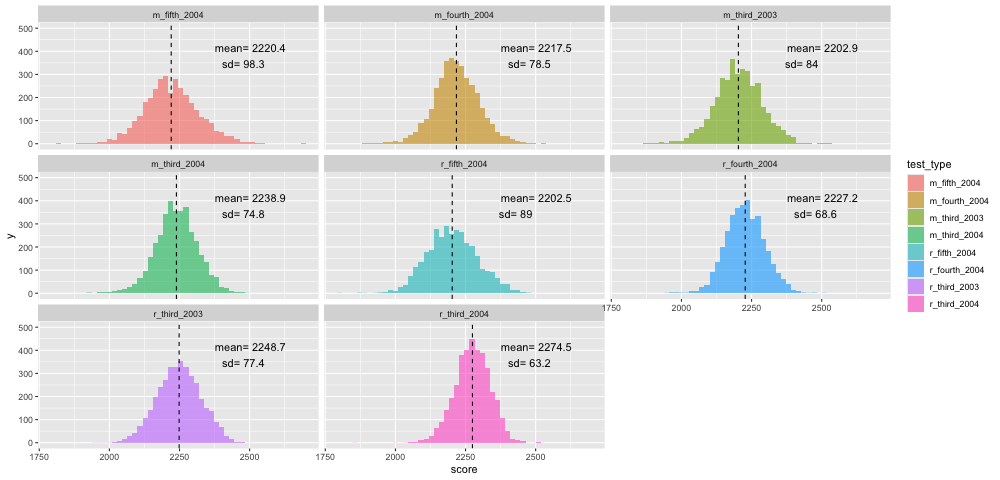

In [11]:
%%R -i df_long -w 1000

ggplot(df_long) + 
    aes(x=score, fill=test_type) +
    geom_histogram(alpha=0.6, bins=50, position='identity') + 
    facet_wrap(~test_type) +
    # plot the mean of each facet as a vline
    geom_vline(data=group_by(df_long, test_type) %>% summarise(mean_score=mean(score)), aes(xintercept=mean_score), color='black', linetype='dashed') + 
    # display the mean as a label
    geom_text (data=group_by(df_long, test_type) %>% summarise(mean_score=mean(score)), aes(x=2250, y=500, label=paste("mean=", round(mean_score, 1))), hjust=-.5, vjust=3, color='black') +
    # display stdev as label
    geom_text (data=group_by(df_long, test_type) %>% summarise(sd_score=sd(score)), aes(x=2250, y=500, label=paste("sd=", round(sd_score, 1))), hjust=-1, vjust=5, color='black') 

# Linear Regressions

👉 Make a scatter plot of third grade reading scores in 2003 vs fourth grade reading scores in 2004. This is theoretically the same(-ish) cohort. Remember, we're interested in **explaining the variance in 2004 fourth grade reading scores**, so we'll keep that as the y.

In [12]:
%%R -i df

# Filter out na values
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(r_third_2003), !is.na(r_fourth_2004))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3501 rows after filtering out na values"


--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Austria (Wien 1) [https]
 6: Belgium (Brussels) [https]
 7: Brazil (PR) [https]
 8: Brazil (SP 1) [https]
 9: Brazil (SP 2) [https]
10: Bulgaria [https]
11: Canada (MB) [https]
12: Canada (ON 1) [https]
13: Canada (ON 2) [https]
14: Chile (Santiago) [https]
15: China (Beijing 2) [https]
16: China (Beijing 3) [https]
17: China (Hefei) [https]
18: China (Hong Kong) [https]
19: China (Jinan) [https]
20: China (Lanzhou) [https]
21: China (Nanjing) [https]
22: China (Shanghai 2) [https]
23: China (Shenzhen) [https]
24: China (Wuhan) [https]
25: Colombia (Cali) [https]
26: Costa Rica [https]
27: Cyprus [https]
28: Czech Republic [https]
29: Denmark [https]
30: East Asia [https]
31: Ecuador (Cuenca) [https]
32: France (Lyon 1) [https]
33: France (Lyon 2) [https]
34: France (Paris 1) [h

Selection:  66



The downloaded binary packages are in
	/var/folders/2h/mxr2292918v68144kbqd531r0000gn/T//RtmpY8Cwfg/downloaded_packages
`geom_smooth()` using formula = 'y ~ x'


trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-arm64/contrib/4.4/ggrepel_0.9.6.tgz'
Content type 'application/octet-stream' length 624147 bytes (609 KB)
downloaded 609 KB

In addition: Warning message:
In doTryCatch(return(expr), name, parentenv, handler) :
  unable to load shared object '/Library/Frameworks/R.framework/Resources/modules//R_X11.so':
  dlopen(/Library/Frameworks/R.framework/Resources/modules//R_X11.so, 0x0006): Library not loaded: /opt/X11/lib/libSM.6.dylib
  Referenced from: <34C5A480-1AC4-30DF-83C9-30A913FC042E> /Library/Frameworks/R.framework/Versions/4.4-arm64/Resources/modules/R_X11.so
  Reason: tried: '/opt/X11/lib/libSM.6.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/X11/lib/libSM.6.dylib' (no such file), '/opt/X11/lib/libSM.6.dylib' (no such file), '/usr/local/lib/libSM.6.dylib' (no such file), '/usr/lib/libSM.6.dylib' (no such file, not in dyld cache)


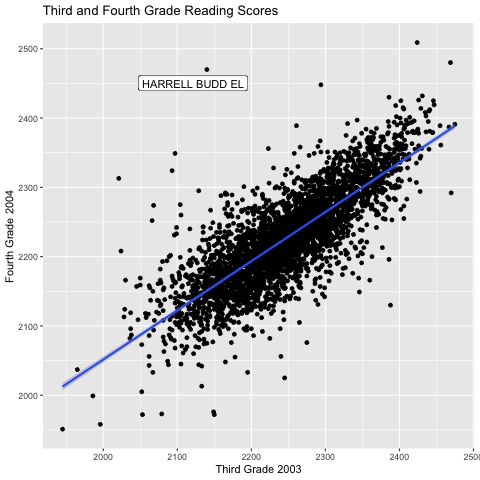

In [14]:
%%R -i df 
install.packages("ggrepel")
library(ggrepel) 

# Make a scatterplot of reading scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
df_filtered %>% 
  ggplot(aes(r_third_2003, r_fourth_2004)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Third and Fourth Grade Reading Scores", x = "Third Grade 2003", y = "Fourth Grade 2004")


### How well do last year's third grade reading scores explain this year's foruth grade reading scores?

In [15]:
%%R 

model <- lm(r_fourth_2004 ~ r_third_2003, data=df_filtered)
summary(model)


Call:
lm(formula = r_fourth_2004 ~ r_third_2003, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-200.32  -23.78    0.70   24.15  319.17 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.327e+02  1.994e+01   31.74   <2e-16 ***
r_third_2003 7.094e-01  8.861e-03   80.06   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 40.91 on 3499 degrees of freedom
Multiple R-squared:  0.6469,	Adjusted R-squared:  0.6468 
F-statistic:  6410 on 1 and 3499 DF,  p-value: < 2.2e-16



### How much does `HARRELL BUDD EL` deviate from the model?

In [16]:
%%R -o df_filtered

df_filtered <- df_filtered %>% 
  mutate(
    predicted = predict(model), # Calculate the predicted values
    residuals = residuals(model), # Calculate the residuals
    standardized_residuals = rstandard(model) # Calculate the standardized residuals (z-scores of residuals
  ) %>% 
  arrange(desc(standardized_residuals)) # sort by standardized residuals

df_filtered %>% select(CNAME, r_third_2003, r_fourth_2004, predicted, standardized_residuals) %>% head(20)

               CNAME r_third_2003 r_fourth_2004 predicted
799  HARRELL BUDD EL         2140          2470  2150.828
2426 TEKOA ACADEMY O         2021          2313  2066.409
105  HIGGS/CARTER/KI         2097          2349  2120.324
1873  HENDERSON N EL         2093          2324  2117.486
2916 MIMI FARLEY ELE         2294          2448  2260.077
747  PINNACLE SCHOOL         2068          2274  2099.751
2525       SARITA EL         2424          2509  2352.301
1662  CHILDREN FIRST         2066          2252  2098.332
1195 PRAIRIE VIEW EL         2261          2389  2236.667
859  WILLIAM B MILLE         2129          2295  2143.025
1776 LAKEWOOD ELEMEN         2104          2275  2125.290
363        DEKALB EL         2223          2356  2209.709
701    SIDNEY SCHOOL         2024          2208  2068.537
1814      BASTIAN EL         2105          2260  2125.999
2163  HARTLEY SCHOOL         2159          2288  2164.307
2435          LEE EL         2165          2292  2168.564
1933        SC

# Do we see suspicious activity in the math scores too?

In [24]:
%%R -i df

# Filter out na values
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(m_third_2003), !is.na(m_fourth_2004))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3501 rows after filtering out na values"


`geom_smooth()` using formula = 'y ~ x'


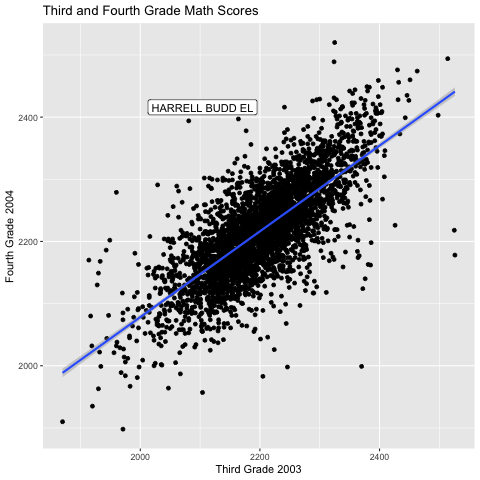

In [25]:
%%R -i df 
library(ggrepel) 

# Make a scatterplot of math scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
df_filtered %>% 
  ggplot(aes(m_third_2003, m_fourth_2004)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Third and Fourth Grade Math Scores", x = "Third Grade 2003", y = "Fourth Grade 2004")


Let's do the same analysis for the math scores. 

👉 Make a scatter plot of third grade math scores in 2003 vs fourth grade math scores in 2004. This is theoretically the same(-ish) cohort. 

Remember, we're interested in **explaining the variance in 2004 fourth grade math scores** now, so we'll keep that as the y.

### How well do last year's third grade math scores explain this year's fourth grade math scores?

In [26]:
%%R 
5
model <- lm(m_fourth_2004 ~ m_third_2003, data=df_filtered)
summary(model)


Call:
lm(formula = m_fourth_2004 ~ m_third_2003, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-334.47  -31.24    0.39   32.56  259.83 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  699.01661   23.12570   30.23   <2e-16 ***
m_third_2003   0.68964    0.01049   65.74   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.41 on 3499 degrees of freedom
Multiple R-squared:  0.5526,	Adjusted R-squared:  0.5525 
F-statistic:  4322 on 1 and 3499 DF,  p-value: < 2.2e-16



### 👉 The R^2 value is 0.5525 which means that 55% of the 2004 math values can be explained by the 2003 math values. The p value is tiny which means that this line is not random.

### How much does `HARRELL BUDD EL` deviate from the model?

In [27]:
%%R -o df_filtered

df_filtered <- df_filtered %>% 
  mutate(
    predicted = predict(model), # Calculate the predicted values
    residuals = residuals(model), # Calculate the residuals
    standardized_residuals = rstandard(model) # Calculate the standardized residuals (z-scores of residuals
  ) %>% 
  arrange(desc(standardized_residuals)) # sort by standardized residuals

df_filtered %>% select(CNAME, m_third_2003, m_fourth_2004, predicted, standardized_residuals) %>% head(20)

               CNAME m_third_2003 m_fourth_2004 predicted
799  HARRELL BUDD EL         2081          2394  2134.167
3837    MEMORIAL INT         1960          2279  2050.720
2525       SARITA EL         2325          2520  2302.441
2916 MIMI FARLEY ELE         2164          2397  2191.408
1486 POWELL POINT EL         2029          2291  2098.306
354  BORDEN COUNTY S         2324          2489  2301.751
859  WILLIAM B MILLE         2177          2378  2200.373
965  HILLSIDE ACAD F         2241          2416  2244.511
714   OGLESBY SCHOOL         2061          2289  2120.374
2446   BLANCHETTE EL         1949          2202  2043.134
1662  CHILDREN FIRST         2064          2281  2122.443
2387 SIERRA BLANCA S         1914          2170  2018.997
2644    O'DONNELL EL         2185          2356  2205.890
1831       BURRUS EL         2107          2302  2152.098
3382         WEST EL         2083          2285  2135.547
945  BEAVER TECHNOLO         2288          2426  2276.924
2679 EOAC WACO

## The maths value have a standarized residual value of 4.96 which is less than the standarized residual of reading scores.

# What are your next steps?

#### 👉 Do more EDA, look at reading and math scores for third graders in 2003 and fourth graders in 2004.

In [28]:
%%R -i df

# Filter out na values
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(r_third_2003), !is.na(m_third_2003))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3703 rows after filtering out na values"



The downloaded binary packages are in
	/var/folders/2h/mxr2292918v68144kbqd531r0000gn/T//RtmpY8Cwfg/downloaded_packages
`geom_smooth()` using formula = 'y ~ x'


trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-arm64/contrib/4.4/ggrepel_0.9.6.tgz'
Content type 'application/octet-stream' length 624147 bytes (609 KB)
downloaded 609 KB



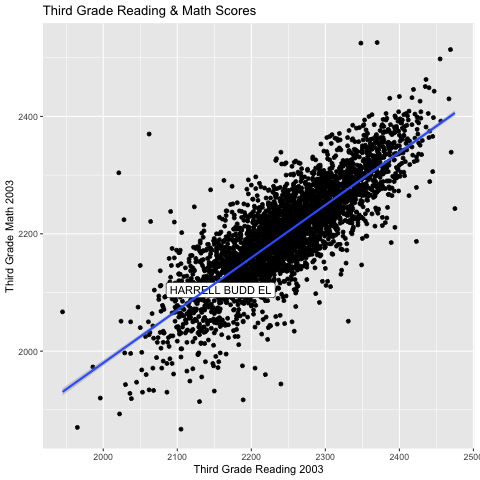

In [29]:
%%R -i df 
install.packages("ggrepel")
library(ggrepel) 

# Make a scatterplot of reading scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
df_filtered %>% 
  ggplot(aes(r_third_2003, m_third_2003)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Third Grade Reading & Math Scores", x = "Third Grade Reading 2003", y = "Third Grade Math 2003")


In [30]:
%%R 
5
model <- lm(m_third_2003 ~ r_third_2003, data=df_filtered)
summary(model)


Call:
lm(formula = m_third_2003 ~ r_third_2003, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-251.15  -28.27    0.13   29.12  334.51 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  185.89303   22.62187   8.217 2.84e-16 ***
r_third_2003   0.89699    0.01005  89.218  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.3 on 3701 degrees of freedom
Multiple R-squared:  0.6826,	Adjusted R-squared:  0.6825 
F-statistic:  7960 on 1 and 3701 DF,  p-value: < 2.2e-16



In [31]:
%%R -i df

# Filter out na values
print(paste(nrow(df), "rows before filtering out na values"))
df_filtered <- df %>% filter(!is.na(r_third_2004), !is.na(m_third_2004))
print(paste(nrow(df_filtered), "rows after filtering out na values"))

[1] "4284 rows before filtering out na values"
[1] "3745 rows after filtering out na values"



The downloaded binary packages are in
	/var/folders/2h/mxr2292918v68144kbqd531r0000gn/T//RtmpY8Cwfg/downloaded_packages
`geom_smooth()` using formula = 'y ~ x'


trying URL 'https://repo.miserver.it.umich.edu/cran/bin/macosx/big-sur-arm64/contrib/4.4/ggrepel_0.9.6.tgz'
Content type 'application/octet-stream' length 624147 bytes (609 KB)
downloaded 609 KB



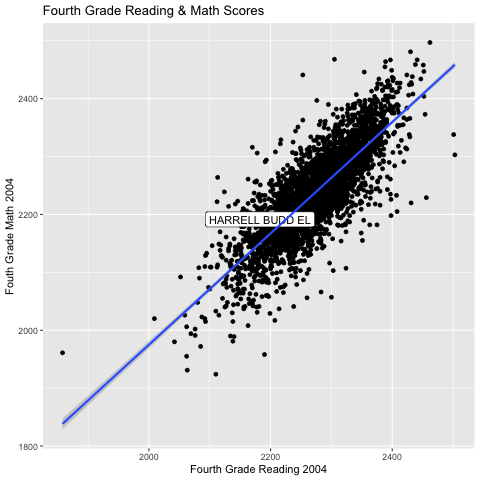

In [32]:
%%R -i df 
install.packages("ggrepel")
library(ggrepel) 

# Make a scatterplot of reading scores from 2004 vs 2003 
# note: we use third grade in 2003 and fourth grade in 2004
#       to theoretically track the same(ish) students
df_filtered %>% 
  ggplot(aes(r_third_2004, m_third_2004)) +
  geom_point() +
  # Display label for HARRELL BUDD EL
  geom_label_repel(aes(label=CNAME), box.padding=0.35, data=filter(df_filtered, CNAME=="HARRELL BUDD EL")) +
  geom_smooth(method = "lm") + 
  labs(title = "Fourth Grade Reading & Math Scores", x = "Fourth Grade Reading 2004", y = "Fouth Grade Math 2004")


In [33]:
%%R 
5
model <- lm(m_third_2004 ~ r_third_2004, data=df_filtered)
summary(model)


Call:
lm(formula = m_third_2004 ~ r_third_2004, data = df_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-206.437  -25.695   -0.093   27.027  222.764 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  51.47948   25.59941   2.011   0.0444 *  
r_third_2004  0.96172    0.01125  85.483   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 43.52 on 3743 degrees of freedom
Multiple R-squared:  0.6613,	Adjusted R-squared:  0.6612 
F-statistic:  7307 on 1 and 3743 DF,  p-value: < 2.2e-16



# Read the Dallas Morning News article

Don't do this step until you've finished all of the above. See what their next steps were and compare them to what you thought to do.

https://courseworks2.columbia.edu/courses/193326/assignments/1229548